In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import RFECV, mutual_info_classif

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [2]:
# Using seaborn's style
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": False,
        "font.family": "serif",
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 10,
        "font.size": 10,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
}

plt.rcParams.update(nice_fonts)

def set_size(width, fraction=1):
    """ Set aesthetic figure dimensions to avoid scaling in latex.

    Parameters
    ----------
    width: float
            Width in pts
    fraction: float
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

width = 418.25368

## Load data

In [3]:
def get_data():
    
    try:
        columns = np.load("data_columns.npy")
        X = np.load("data_valence_physio_for_svm_only_valid_session.npy")
        Y = np.load("data_valence_label_for_svm_only_valid_session.npy")
        return pd.DataFrame(X, columns=columns), pd.DataFrame(Y)
    except:
        print "No stored files found.. load from files first"

In [20]:
X, Y = get_data()
print X.shape
print Y.shape

(82400, 24)
(82400, 1)


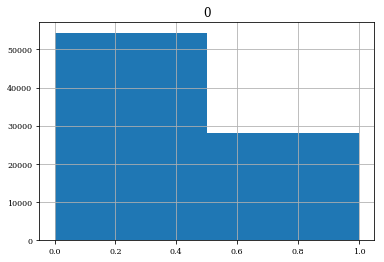

In [21]:
# binarize the problem
Y[Y<=4] = 0
Y[Y>=5] = 1
Y.hist(bins=2)
Y = Y.values.ravel()

## LinearSVC

### Search for optimal C parameter

In [76]:
from sklearn.model_selection import GridSearchCV
lsvc = LinearSVC(dual=False, fit_intercept=False, class_weight='balanced')
parameters = {
    'C': [ 1*10**i for i in range(3,-6,-1) ], 
    'tol' : [ 1*10**i for i in range(-1,-6,-1) ]
}
clf = GridSearchCV(lsvc, parameters, scoring='balanced_accuracy')
clf.fit(X, Y)

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight='balanced', dual=False, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05], 'tol': [0.1, 0.01, 0.001, 0.0001, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

In [79]:
clf

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight='balanced', dual=False, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 1e-05], 'tol': [0.1, 0.01, 0.001, 0.0001, 1e-05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='balanced_accuracy', verbose=0)

In [72]:
result = []

for i in range(10,-10,-1):
    c = 1*10**i
    # reshape data for estimator
    lsvc = LinearSVC(C=c, tol=1e-4, dual=False, fit_intercept=False, class_weight='balanced', random_state=seed, verbose=True)

    # evaluate using 5-fold cross validation
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    results = cross_val_score(lsvc, X, Y, cv=stratified_cv, scoring='balanced_accuracy', verbose=0)

    result.append({ "c": c, "score" : results.mean()*100, "std" : results.std()*100})

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

In [73]:
max_score = max(result, key=lambda x: x["score"])

print "optimal value: {}".format(max_score["c"])
print("Accuracy: %.2f%% (%.2f%%)" % (max_score["score"], max_score["std"]))

optimal value: 1000000
Accuracy: 60.57% (0.34%)


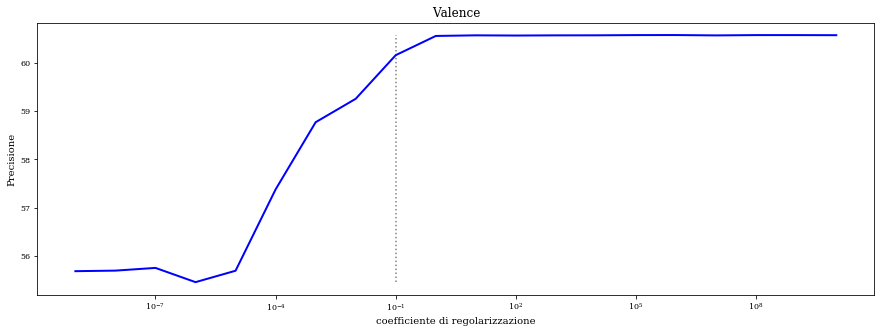

In [74]:
results = { r["c"] : r for r in result }
c_values = list(sorted(results.keys()))
scores = [ results[c]["score"] for c in c_values ]
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 1, 1)
line, = ax.plot(c_values, scores, color='blue', lw=2)
ax.vlines([1e-1], min(scores), max(scores), colors='gray', linestyles="dotted")
ax.set_xscale('log')
ax.set_title("Valence")
ax.set_ylabel("Precisione")
ax.set_xlabel("coefficiente di regolarizzazione")
plt.show()
fig.savefig("reg_coef_val.pdf", format="pdf", bbox_inches='tight')

Create classifier with optimal parameter

In [80]:
def create_classifier():
    lsvc = LinearSVC(C=1000000, tol=1e-4, dual=False, fit_intercept=False, class_weight='balanced', random_state=seed, verbose=True)
    # evaluate using 5-fold cross validation
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    return lsvc, stratified_cv

## KBest Feature selection + SVC

In [50]:
# Such a large set of features can cause overfitting and also slow computing
# Use feature selection to select the most important features
from sklearn.feature_selection import SelectKBest, f_classif, chi2

In [81]:
scores_by_kbest = []

for k in range(1,25):

    lsvc, stratified_cv = create_classifier() 
    kbest_selector = SelectKBest(k=k)
    kbest_selector.fit(X, Y)
    
    results = cross_val_score(lsvc, kbest_selector.transform(X), Y, scoring='balanced_accuracy', cv=stratified_cv, verbose=0)

    ks = {
        "feature" : X.columns[kbest_selector.get_support()],
        "score" : results.mean(),
        "std"   : results.std()
    }
    
    scores_by_kbest.append(ks)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear

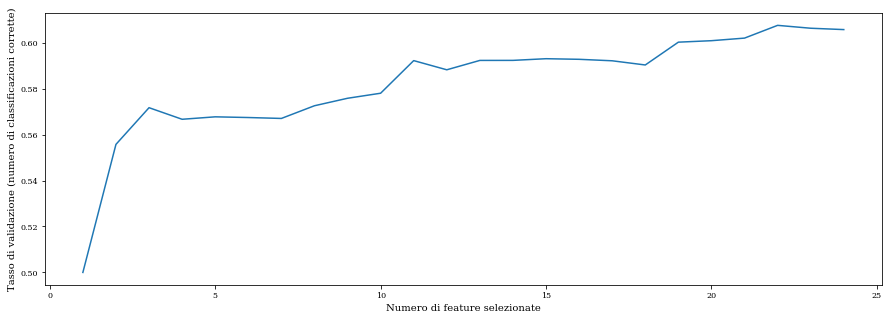

In [82]:
nfeature = [ len(s["feature"]) for s in scores_by_kbest ]
scores = [ s["score"] for s in scores_by_kbest ]
plt.figure(figsize=(15,5))
plt.xlabel("Numero di feature selezionate")
plt.ylabel("Tasso di validazione (numero di classificazioni corrette)")
plt.plot(nfeature, scores)
plt.show()

In [83]:
max_score = max(scores_by_kbest, key=lambda x: x["score"])

print("Optimal number of features : %d" % len(max_score["feature"]))
print max_score["feature"]

print
print("Accuracy: %.2f%% (%.2f%%)" % (max_score["score"]*100, max_score["std"]*100))

Optimal number of features : 22
Index([u'ECG_mean', u'ECG_std', u'ECG_min', u'ECG_max', u'ECG_mean_diff',
       u'ECG_mean_abs_diff', u'EDA_mean', u'EDA_std', u'EDA_min', u'EDA_max',
       u'EDA_mean_diff', u'EDA_mean_abs_diff', u'Resp_mean', u'Resp_std',
       u'Resp_min', u'Resp_mean_abs_diff', u'SKT_mean', u'SKT_std', u'SKT_min',
       u'SKT_max', u'SKT_mean_diff', u'SKT_mean_abs_diff'],
      dtype='object')

Accuracy: 60.75% (0.25%)


## Recursive feature selection

In [84]:
lsvc, stratified_cv = create_classifier()
rfecv = RFECV(estimator=lsvc, step=1, cv=stratified_cv, scoring='balanced_accuracy', n_jobs=-1)

In [85]:
rfecv.fit(X, Y)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

RFECV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
   estimator=LinearSVC(C=1000000, class_weight='balanced', dual=False, fit_intercept=False,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=7, tol=0.0001,
     verbose=True),
   min_features_to_select=1, n_jobs=-1, scoring='balanced_accuracy',
   step=1, verbose=0)

In [86]:
rfecv.estimator_.coef_

array([[ 0.15800675,  0.28068387, -3.01042257, -0.3876203 , -0.35720691,
        -0.38881933,  3.11374498, -1.03906992,  0.47967365,  1.48978345,
        -0.2204974 ,  8.40126117, -2.21708658, -4.34104648, -4.13270019,
         0.35400914,  2.62124643]])

In [87]:
print("Optimal number of features : %d" % rfecv.n_features_)
print X.columns[rfecv.get_support()]

print
print("Accuracy: %.2f%% (%.2f%%)" % (rfecv.grid_scores_[rfecv.n_features_ - 1]*100, 0))

Optimal number of features : 17
Index([u'ECG_mean', u'EDA_mean', u'EDA_std', u'EDA_min', u'EDA_max',
       u'EDA_mean_diff', u'EDA_mean_abs_diff', u'Resp_mean', u'Resp_std',
       u'Resp_min', u'Resp_mean_abs_diff', u'SKT_mean', u'SKT_std', u'SKT_min',
       u'SKT_max', u'SKT_mean_diff', u'SKT_mean_abs_diff'],
      dtype='object')

Accuracy: 60.74% (0.00%)


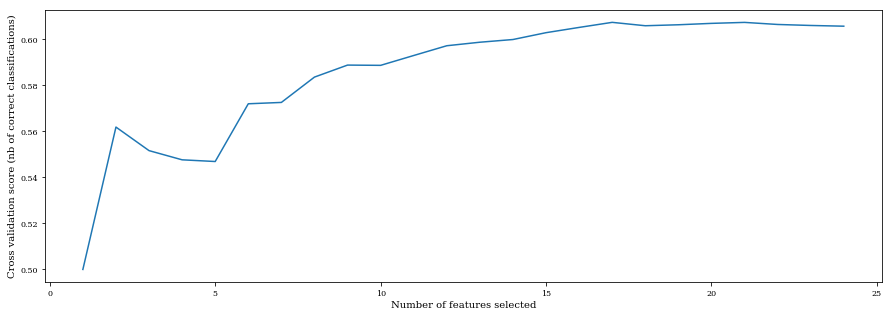

In [88]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(15,5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()